In [1]:
import numpy as np
import pickle
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
traj_tr = pickle.load(open('trajDr_tr.pkl', 'rb'))

In [3]:
nS, nA = 750, 25

In [4]:
# Count frequency of each transition
policy_counts = np.zeros((nS, nA), dtype=int)
for trajectory in tqdm(traj_tr):
    for t, transition in enumerate(trajectory):
        s = transition['s']
        a = transition['a']
        policy_counts[s][a] += 1

100%|██████████| 14657/14657 [00:00<00:00, 40651.15it/s]


In [5]:
policy_counts[0]

array([129,   0,   0,   3,   0, 212,  10,   3,  16,   9,  39,   3,   2,
         1,   4,   7,   3,   1,   3,   1,   1,   0,   0,   1,   0])

In [6]:
# only allow actions *frequently* used by clinicians (at least 5 times)
Q_mask = (policy_counts >= 5)

In [7]:
# For states without any available actions, allow the most frequent action
for s in range(nS):
    if Q_mask[s].sum() == 0:
        Q_mask[s, policy_counts[s].argmax()] = True

In [8]:
Q_mask[157]

array([ True, False, False, False, False,  True,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [9]:
# every state has at least one action, |A(s)| >= 1
(Q_mask.sum(axis=1) > 0).all()

True

In [10]:
np.save('action_mask.npy', Q_mask)

In [11]:
Q_mask.mean()

0.24144

In [12]:
import matplotlib.pyplot as plt

In [13]:
policy_counts.sum(axis=1).shape

(750,)

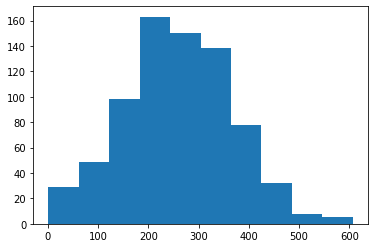

In [14]:
plt.hist(policy_counts.sum(axis=1))
plt.show()

In [15]:
# Empirically estimate the clinicians' policy
policy_counts = defaultdict(lambda: defaultdict(int))
for trajectory in tqdm(traj_tr):
    for t, transition in enumerate(trajectory):
        s = transition['s']
        a = transition['a']
        if Q_mask[s,a]:
            policy_counts[s][a] += 1

100%|██████████| 14657/14657 [00:00<00:00, 46492.53it/s]


In [16]:
# Renormalize policy probabilities
pi_0 = defaultdict(dict)
for s in tqdm(range(nS)):
    emp_counts = policy_counts[s]
    if len(emp_counts) == 0:
        assert False
    else:
        norm_const = sum(emp_counts.values())
        for a, count in emp_counts.items():
            prob = float(count) / float(norm_const)
            pi_0[s][a] = prob

100%|██████████| 750/750 [00:00<00:00, 67728.72it/s]


In [17]:
pi_0[10]

{0: 0.26884422110552764,
 5: 0.6130653266331658,
 10: 0.10301507537688442,
 15: 0.01507537688442211}

In [18]:
pi_0[157]

{0: 0.14942528735632185,
 5: 0.6954022988505747,
 10: 0.08620689655172414,
 8: 0.017241379310344827,
 9: 0.03735632183908046,
 6: 0.014367816091954023}

In [19]:
with open('clinician_policy.p', 'wb') as f:
    pickle.dump(pi_0, f)